# Evenements culturels : Création d'une carte interactive

Durant ce projet, nous allons utiliser la base de données répertoriant les évènements culturels en île de France (https://data.iledefrance.fr/explore/dataset/evenements-publics-cibul/table/) pour extraire les différents évènements et récupérer les informations importantes comme la date, le prix, ou le sujet et les mettre sous des formes faciles à utiliser.

Tout d'abord, nous allons import le dataframe et récupérer les informations que nous pouvons principalement grâce à des expressions régulières et à du web scraping. Ensuite, pour obtenir le sujet des évènements nous allons utiliser du NLP en trouvant les termes revenant le plus souvent. Finalement, nous finirons par analyser les données trouvées.

from datetime import time## Installations et imports de modules

In [1]:
# Trivia
import pandas as pd
import numpy as np
from collections import Counter

# Regex
import re

# API, data import
import urllib
import bs4
from urllib import request
import requests

# User informations
import sys
!{sys.executable} -m pip install geopy
import geopy
from geopy.geocoders import Nominatim
from geopy import distance
import datetime as dt

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re

# Natural Language Processing
!pip install nltk
import nltk
from nltk.corpus import stopwords
from time import time
#from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
!pip install pywaffle
from pywaffle import Waffle
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

!pip install spacy
!pip install https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.1.0/fr_core_news_sm-3.1.0.tar.gz

import spacy

nlp = spacy.load("fr_core_news_sm")

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     |████████████████████████████████| 17.1 MB 17 kB/s             
  Preparing metadata (setup.py) ... done


## Données : Collecte et Nettoyage

In [58]:
class User:
    ''' The User Class allows us to store every piece of information about the User '''
    
    def __init__(self, address, date, price_max = 42):
        geolocator = Nominatim(user_agent="CulturalEvents")
        location = geolocator.geocode(address)
        self.latlon = (location.latitude, location.longitude)
        self.date = date
        self.price_max = price_max
        
Naclanga = User("27 Boulevard Thomas Gobert, Palaiseau", dt.date.today())

In [60]:
# Query to extract a specific frame of time, the user desired date
query = "date_start < " + str(Naclanga.date + dt.timedelta(days=7)) + " AND date_start > "  + str(Naclanga.date)

# Request. We can extract up to 1000 rows but it can be time consuming, that's why we restrict the timeframe
url = "https://data.iledefrance.fr/api/records/1.0/search/?dataset=evenements-publics-cibul&q=&rows=1000&q=(" + query + ")&sort=date_start"
req = requests.get(url)
df = pd.json_normalize(req.json()['records'])

# Rename the columns
important_keys = ["fields.title", "fields.latlon", "fields.date_start", "fields.tags", "fields.pricing_info", "fields.description",'fields.link', 'fields.free_text', 'fields.address', 'fields.department','fields.placename', 'fields.region', 'fields.date_end', 'fields.lang', 'geometry.type', 'geometry.coordinates', 'fields.city_district']
df = df[important_keys]
dict_important_keys = {elt : elt.replace("fields.", "") for elt in important_keys}
df.rename(columns = dict_important_keys, inplace=True)

df_to_treat = df.copy()
df_to_treat

,title,latlon,date_start,tags,pricing_info,description,link,free_text,address,department,placename,region,date_end,lang,geometry.type,geometry.coordinates,city_district
0,Actif!,"[48.867609, 2.352198]",2022-01-11,Exposition,Sur inscription,"Lorem ipsum dolor sit amet, consectetur adipis...",http://openagenda.com/event/actif,"Lorem ipsum dolor sit amet, consectetur adipis...","29 passage du ponceau, paris",NaN,Test OA,Île-de-France,2022-01-11,fr,Point,"[2.352198, 48.867609]",Paris 2e Arrondissement
1,LE ROI LOUIS REND SON ÂME,"[48.84834, 2.351983]",2022-01-11,NaN,NaN,Un jour dans l’histoire.,http://openagenda.com/event/le-roi-louis-rend-...,Informations\r\n\r\nhttps://www.collegedesbern...,"20 Rue de Poissy, 75005 Paris, France",Paris,Collège des Bernardins,Île-de-France,2022-01-11,fr,Point,"[2.351983, 48.84834]",5e Arrondissement
2,"La Genèse de Vienne, un exemple de recherche i...","[48.866484, 2.338931]",2022-01-11,La Fabrique de l’art : utilisation des données...,NaN,Séminaire,http://openagenda.com/event/la-genese-de-vienn...,La Genèse de Vienne est un manuscrit écrit à l...,"2, rue Vivienne ou 6 rue des Petits Champs",Paris,Institut national d'histoire de l'art - Galeri...,Île-de-France,2022-01-11,fr,Point,"[2.338931, 48.866484]",Paris 2e Arrondissement
3,Les étapes clés de la création d'entreprise,"[48.787838, 2.050474]",2022-01-11,NaN,Participation gratuite - Inscription obligatoire,Animé par BGE Yvelines,http://openagenda.com/event/les-etapes-cles-de...,"De l'idée au business plan, du financement au ...","3, avenue du centre guyancourt",Yvelines,Webinaire SQY Cub,Île-de-France,2022-01-11,fr,Point,"[2.050474, 48.787838]",NaN
4,GRANDES VOIX DE LA POÉSIE CONTEMPORAINE,"[48.800506, 2.131408]",2022-01-11,NaN,Sur inscription (Cycle de 6 conférences Tarif...,Un nouvel espace pour le poème : Philippe Jacc...,http://openagenda.com/event/grandes-voix-de-la...,Un nouvel espace pour le poème : Philippe Jacc...,"6 impasse des Gendarmes, entrée B 78000 Versai...",Yvelines,Université Ouverte de Versailles,Île-de-France,2022-01-11,fr,Point,"[2.131408, 48.800506]",Chantiers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,Spectacle : Fabrice Eboué,"[48.825113, 2.269746]",2022-01-06,"Fabrice Eboué,humour,one man show",NaN,Découvrez son nouveau spectacle !,http://openagenda.com/event/spectacle-fabrice-...,"Fabrice Eboué est un humoriste, metteur en scè...","11-13 rue Danton, 92130 Issy-les-Moulineaux",Hauts-de-Seine,Auditorium Niedermeyer,Île-de-France,2022-01-06,fr,Point,"[2.269746, 48.825113]",Quartier Centre-Ville / Corentin Celton / Les ...
158,"BLOCKCHAIN, DU THÉÂTRE AU FLASH CRASH","[48.712856, 2.164843]",2022-01-06,"Théâtre Création scènique,Danse. vidéos",Gratuit sur inscription - pour 10-12 étudiants...,Participer activement aux premières étapes d’u...,http://openagenda.com/event/blockchain-du-thea...,Ce Projet Interdisciplinaire Collectif propose...,4 avenue des Sciences - Gif-sur-Yvette,Essonne,ENS Paris-Saclay,Île-de-France,2022-04-15,fr,Point,"[2.164843, 48.712856]",NaN
159,L'ATLANTIQUE / LA TRAVERSÉE,"[48.835058, 2.450684]",2022-01-06,NaN,"payant, sur réservation",Avez-vous déjà rêvé de traverser l’océan vers ...,http://openagenda.com/event/latlantique-la-tra...,C’est en marchant dans la rade de Cherbourg qu...,"Route du Champ de Manoeuvre, 75012 Paris",Paris,Théâtre de l'Epée de Bois - Cartoucherie,Île-de-France,2022-01-09,fr,Point,"[2.450684, 48.835058]",NaN
160,BEN MAZUE,"[48.766645, 1.948273]",2022-01-06,NaN,"A partir de 22,00€",PARADIS TOUR,http://openagenda.com/event/ben-mazue-3064655,""" Pour moi le PARADIS c’est un endroit, c’est ...",Centre des 7 Mares,NaN,Le Prisme,NaN,2022-01-06,fr,Point,"[1.948273, 48.766645]",NaN


### Calcul de la distance

Grâce aux informations contenues dans le tableau et celles fournies par l'utilisateur. On peut calculer la distance géographique entre l'évènement et l'adresse de l'utilisateur

In [61]:
df_to_treat['distance'] = df['latlon'].apply(lambda x: distance.distance(x, Naclanga.latlon).km)
df_to_treat['distance']

0      20.568634
1      18.805619
2      19.943270
3      13.712115
4      10.917727
         ...    
157    13.522649
158     2.486443
159    22.968973
160    19.357635
161    18.518427
Name: distance, Length: 162, dtype: float64

### Extraction du prix

Dans ce second cas les informations sont dans le tableau mais pas sous une forme très utile. Par conséquent on utilise les expressions régulières pour obtenir des prix en nombre

In [65]:
def extract_price_regex(x):
    ''' Returns an estimation of the price of the event '''
    
    # Multiple price can be there so we are going to find them all and compute the mean
    L = []
    for k in re.findall("\S+\s?€", str(x)):
        try:
            a = float(k.replace("€", "").replace(",", ".")) # Conversion

        # If there is no price or it doesn't work
        except ValueError:
            a = float("NaN")
        
        L.append(a)
        
    return np.mean(L)

df_to_treat['pricing_info'] = df['pricing_info'].apply(lambda x:extract_price_regex(x))

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [66]:
df_to_treat['pricing_info']

0         NaN
1         NaN
2         NaN
3         NaN
4      108.18
        ...  
157       NaN
158       NaN
159       NaN
160     22.00
161       NaN
Name: pricing_info, Length: 162, dtype: float64

### Extraction des horaires

Dans le troisième cas, l'information n'est pas dans le tableau mais on peut la trouver grâce au lien associé, d'où l'utilisation de webscraping.

In [7]:
def get_text(link):
    ''' Requests the html code of the page '''
    request_text = request.urlopen(link).read()
    page = bs4.BeautifulSoup(request_text)
    return(page)

def get_hours_regex(text):
    ''' Returns the hours of opening on the html page '''
    return str(text.select('span.hour')[0]).replace('<span class="hour">', "").replace("</span>", "")
    
def get_timespan(link):
    ''' Given a link, this function uses the last two to return the hours of opening '''

    try:
        text = get_text(link)
        hours = get_hours_regex(text).split('-')
        hours[0] = hours[0].replace(" ", "")
        hours[1] = hours[1].replace(" ", "")

    except (urllib.error.HTTPError, IndexError): # If the Event is not correctly setup (error 404) or the event is not accessible (error 403)
        hours = float("NaN")
        
    return hours

# Time consuming, so we should get all information at once to avoid doing too much webscraping
df_to_treat['opening_hours'] = df['link'].apply(lambda link: get_timespan(link))

# Should we differency ponctual events (movies, plays, sports) and long running events (expositions) ?
# -> We can probably do it judging the timespan of the events in terms of days and hours, but is it useful ?

In [8]:
df_to_treat['opening_hours']

0      [10:00, 11:30]
1      [12:45, 13:45]
2      [14:00, 16:30]
3      [14:00, 18:00]
4      [16:30, 18:00]
            ...      
157    [20:30, 22:00]
158    [14:00, 16:00]
159    [21:00, 22:15]
160    [20:30, 22:30]
161    [20:00, 20:30]
Name: opening_hours, Length: 162, dtype: object

In [9]:
def duration(t):
    ''' '''
    try:
        end = dt.datetime.combine(dt.date.fromisoformat(str(t['date_end'])), dt.time.fromisoformat(str(t['opening_hours'][1])))
        start = dt.datetime.combine(dt.date.fromisoformat(str(t['date_start'])), dt.time.fromisoformat(str(t['opening_hours'][0])))
    
        return end - start
    
    except TypeError:
        
        return float("NaN")

df_to_treat['duration'] = df_to_treat[['opening_hours','date_end', 'date_start']].apply(lambda x: duration(x), axis=1)
df_to_treat['duration']

0      0 days 01:30:00
1      0 days 01:00:00
2      0 days 02:30:00
3      0 days 04:00:00
4      0 days 01:30:00
            ...       
157    0 days 01:30:00
158   99 days 02:00:00
159    3 days 01:15:00
160    0 days 02:00:00
161    0 days 00:30:00
Name: duration, Length: 162, dtype: timedelta64[ns]

## Natural Language Processing

### Création de Labels

Nous allons chercher les mots les plus utilisés pour créer des labels. Ici, on utilise toute la base de données sans faire de requête pour avoir le maximum de données

In [10]:
database = pd.read_csv('events_database.zip', compression='zip', header=0, sep=';')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
database[['Description', 'Détails', 'Mots clés']].head(5)

,Description,Détails,Mots clés
0,Découvrir le poney dans un séjour multisports ...,L'UCPA propose ses vacances apprenantes : Un s...,"UCPA,sport,nature,SFJBOI31E,import-ucpa-20200630"
1,"Un séjour qui combine sport, collectivité et f...",Cette colo te permettra de découvrir les multi...,"jeux olympiques,sport,import-pep"
2,Le top de la glisse de la côte californienne,L'UCPA propose ses vacances apprenantes : Un s...,"UCPA,sport,nature,SFJPON34R,import-ucpa-20200630"
3,Compagnie AtmosphèreS - mise en scène : Sara V...,"Camille, Camille, Camille\n-------------------...","Camille Claudel,Rodin,Paul claudel,sculptrice,..."
4,Mise en scène par Agnès Braunschweig. Cie Pros...,Je reviens de la vérité de Charlotte Delbo. Mi...,"Résistance,Déportation,Deuxième guerre mondial..."


In [12]:
def NaN_to_String(dataframe):
    ''' Convert the NaN value to Empty String and returns a cleaner text '''
    df_temp = dataframe.copy()
    df_temp[df_temp.isna()] = ""
    return df_temp.apply(lambda s: s.replace("\n", "").replace("\r", "") + ". ")

# Variable containing every piece of possibly useful text in the database
text_desc = (NaN_to_String(database['Description']) + NaN_to_String(database['Détails']) + NaN_to_String(database['Mots clés']).apply(lambda s: s.replace(",", ", ")))
text_desc

0         Découvrir le poney dans un séjour multisports ...
1         Un séjour qui combine sport, collectivité et f...
2         Le top de la glisse de la côte californienne. ...
3         Compagnie AtmosphèreS - mise en scène : Sara V...
4         Mise en scène par Agnès Braunschweig. Cie Pros...
                                ...                        
142884    Théâtre - Conférence / À partir de 14 ans   Pe...
142885    J'AI DES DOUTES. Molière 2019 du Comédien dans...
142886    Jazz vocal      Une formation alliant l’esprit...
142887    Théâtre   « Femme, réveille-toi » disait Olymp...
142888    CATCH D'IMPRO Encadrés par un arbitre qui s’oc...
Length: 142889, dtype: object

Premier test

On cherche les mots les plus utilisés grâce au module nltk en enlevant les mots qui ne sont pas composés de caractère alphabétique et les mots les plus usités en français (stop_words : le, la ...)

In [13]:
text = text_desc.head(100).sum().lower() # We use only 1000 rows but we can go higher, it just take more time
words = nltk.word_tokenize(text, language='french')
words = [word for word in words if word.isalpha()]
words = [w for w in words if not w in stop_words]
dic_words = Counter(words)

In [14]:
dic_words.most_common(20)

[('a', 55),
 ('https', 46),
 ('cette', 34),
 ('plus', 30),
 ('université', 30),
 ('the', 25),
 ('formation', 24),
 ('paris', 21),
 ('tout', 20),
 ('spectacle', 19),
 ('art', 19),
 ('cadre', 17),
 ('comment', 17),
 ('projet', 16),
 ('recherche', 15),
 ('of', 15),
 ('and', 15),
 ('atelier', 15),
 ('décembre', 15),
 ('séjour', 14)]

Comme on peut le voir beaucoup de mots ne correspondent pas à nos attentes, certains ne sont même pas des mots d'ailleurs.

Une idée serait d'utiliser une méthode d'étiquettage morpho syntaxique, ainsi on pourrait conserver seulement les noms communs. Pour cela il faut utiliser spacy plutôt que nltk car le français n'est pas supporté pour cette méthode dans nltk.

Second Test : L'étiquettage morpho-syntaxique

In [15]:
def return_POS(sentence, n = -1):
    ''' Returns a list of tags, there are the most used nouns in the database. n is the number of tags that we want. If n = -1, every possible tags are returned '''
    
    # Tokenize
    doc = nlp(sentence)
    
    # We only keep words being labellized as nouns
    words = [[X.lemma_, X.lemma_] for X in doc if (X.is_alpha == True and X.pos_ == "NOUN" and not(X in stop_words))]
    df_words = pd.DataFrame(words, columns=['tags', 'unique_tags'])
    
    if n == -1:
        return list(df_words.groupby(['unique_tags']).count().sort_values('tags', ascending=False).to_dict()['tags'].keys())
    else:
        return list(df_words.groupby(['unique_tags']).count().sort_values('tags', ascending=False).head(n).to_dict()['tags'].keys())

In [16]:
tags = return_POS(text_desc.head(1000).sum().lower(), 50)
tags

['musique',
 'atelier',
 'théâtre',
 'concert',
 'projet',
 'visite',
 'scène',
 'monde',
 'histoire',
 'année',
 'groupe',
 'samedi',
 'exposition',
 'jeu',
 'public',
 'enfant',
 'spectacle',
 'an',
 'place',
 'dimanche',
 'création',
 'rencontre',
 'conférence',
 'recherche',
 'association',
 'vie',
 'aide',
 'travers',
 'cadre',
 'découverte',
 'festival',
 'temps',
 'artiste',
 'maison',
 'formation',
 'œuvre',
 'danse',
 'siècle',
 'musée',
 'travail',
 'ville',
 'soirée',
 'journée',
 'heure',
 'université',
 'occasion',
 'programme',
 'chanson',
 'centre',
 'rue']

In [17]:
df_to_treat['text'] = (NaN_to_String(df['tags']) + NaN_to_String(df['title']) + NaN_to_String(df['description']) + NaN_to_String(df['free_text'])).apply(lambda s: s.replace(",", ", "))
df_to_treat['tags'] = df_to_treat['text'].apply(lambda x:return_POS(x.lower()))
df_to_treat['tags'] = df_to_treat['tags'].apply(lambda x: [k for k in x if k in tags])

In [18]:
df_to_treat['tags'] 

0                                           [exposition]
1                                             [histoire]
2      [recherche, histoire, œuvre, centre, projet, u...
3                                     [création, projet]
4                                                [monde]
                             ...                        
157    [spectacle, scène, public, monde, occasion, th...
158    [création, projet, théâtre, musique, danse, re...
159    [spectacle, scène, travail, vie, dimanche, heu...
160        [concert, spectacle, théâtre, artiste, heure]
161                                            [travail]
Name: tags, Length: 162, dtype: object

In [45]:
df_to_treat[df_to_treat['tags'].apply(lambda x:x==[])]

## Visualisation

<AxesSubplot:>

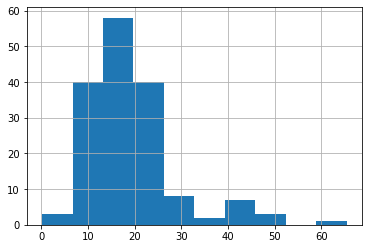

In [62]:
df_to_treat['distance'].hist()

<AxesSubplot:>

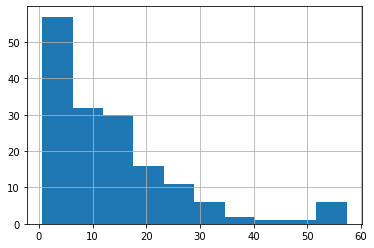

In [52]:
#df_to_treat['distance'].hist()

<AxesSubplot:xlabel='duration'>

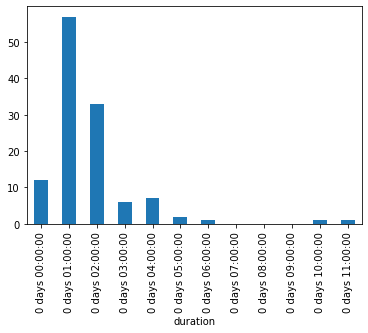

In [51]:
df_to_treat.reset_index()[df_to_treat["duration"].apply(lambda s:s >= dt.timedelta(days = 0) and s <= dt.timedelta(days = 1))].groupby(pd.Grouper(key="duration", freq='H'))['index'].count().plot(kind="bar")

123


<AxesSubplot:xlabel='duration'>

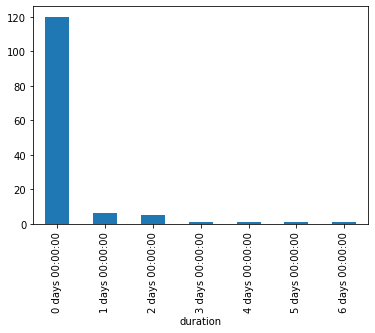

In [48]:
print(len(df_to_treat[df_to_treat["date_start"] == df_to_treat["date_end"]]))
df_to_treat.reset_index()[df_to_treat["duration"].apply(lambda s:s >= dt.timedelta(days = 0) and s <= dt.timedelta(days = 7))].groupby(pd.Grouper(key="duration", freq='D'))['index'].count().plot(kind="bar")

49


<AxesSubplot:>

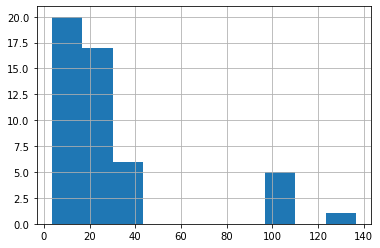

In [73]:
print(len(df_to_treat[df_to_treat['pricing_info'].notna()]))
df_to_treat['pricing_info'].hist()